# How to fit a model

In [2]:
from jax import jit
from gcdyn import responses, bdms, mutators, model
from jaxopt import GradientDescent, ScipyBoundedMinimize
import matplotlib.pyplot as plt
import numpy as np
from ete3.coretype.tree import TreeError

In [3]:
def plot_response(response):
    X = np.arange(-10, 10, 0.5)
    plt.plot(X, response.f(X))
    plt.ylabel("Birth rate")
    plt.show()

def evolve_trees(num_trees, init_x = 0, **evolve_kwargs):
    trees = []
    seed = evolve_kwargs.pop("seed", None)

    for _ in range(num_trees):
        while True:
            try:
                tree = bdms.TreeNode(x = init_x)
                tree.evolve(seed = seed, **evolve_kwargs)
                trees.append(tree)
                break

            except TreeError: # not enough survivors
                seed = seed + 1 if seed is not None else None

        seed = seed + 1 if seed is not None else None

    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")

    return trees

In [4]:
birth_rate = responses.SigmoidResponse(1., 0., 2., 0., grad=True)
death_rate = responses.ConstantResponse(1., grad=True)
mutation_rate = responses.ConstantResponse(1., grad=False)
sampling_probability = 1

mutator = mutators.GaussianMutator(-1, 1)

Average of 299.6666666666667 nodes per tree, over 3 trees

            /-5
           |
           |   /- /-26
           |  |
           |  |      /- /- /-34
           |  |     |
           |  |     |            /- /-50
           |  |   /-|      /- /-|
         /-|  |  |  |     |     |         /-84
        |  |  |  |  |     |      \- /- /-|
        |  |  |  |  |     |               \- /-113
        |  |  |  |   \- /-|
        |  |  |  |        |   /-36
        |  |  |  |        |  |
        |  |  |  |        |  |      /-40
        |  |  |  |         \-|   /-|
        |  |  |  |           |  |   \- /-49
        |   \-|  |           |  |
        |     |  |            \-|      /- /- /- /- /- /-98
        |     |  |              |     |
        |     |  |              |     |   /-58
        |     |  |               \- /-|  |
        |     |  |                    |  |         /-64
        |     |  |                    |  |        |
        |     |  |                    |  |      /-|   /-

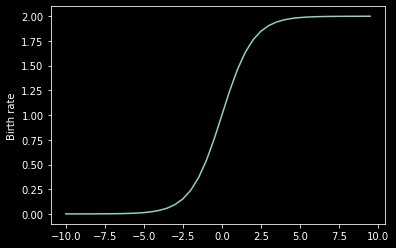

In [5]:
trees = evolve_trees(3, 
    t = 8,
    birth_rate = birth_rate,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    seed = 10
)

for tree in trees:
    tree.sample_survivors(p = sampling_probability, seed = 0)

print(trees[0])
plot_response(birth_rate)

In [6]:
mod = model.BDMSModel(
    trees = trees,
    birth_rate = birth_rate,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    sampling_probability = sampling_probability
)

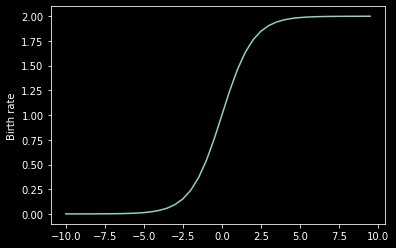

In [7]:
# Initial birth rate
plot_response(birth_rate)

In [8]:
mod.fit()

ScipyMinimizeInfo(fun_val=DeviceArray(1092.76373892, dtype=float64, weak_type=True), success=True, status=0, iter_num=13)

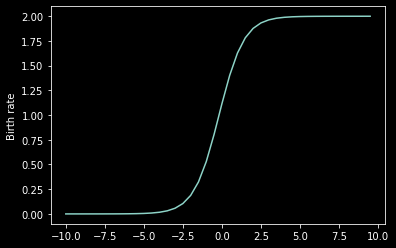

In [9]:
# Fitted birth rate
plot_response(mod.parameters["birth_rate"])

In [10]:
mod.parameters

{'birth_rate': SigmoidResponse(grad=True, xscale=1.2488933953202077, xshift=-0.1820721868359543, yscale=1.9987168440173075, yshift=0.0),
 'death_rate': ConstantResponse(grad=True, value=0.9968573920970746),
 'mutation_rate': ConstantResponse(grad=False, value=1.0)}

In [11]:
# JIT works, this runs faster
mod.fit()

ScipyMinimizeInfo(fun_val=DeviceArray(1092.76373891, dtype=float64, weak_type=True), success=True, status=0, iter_num=1)

In [12]:
x = mod.fit()